In [6]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 98.0 MB/s eta 0:00:00


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import igraph as ig
import numpy as np
from collections import Counter

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Campaigns

To see the way of the events spreading acoress people

In [4]:
campaigns = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ECE227/campaigns.csv', sep=';', header=None)
campaigns.columns = ['campaign_id', 'timestamp', 'sender_id', 'receiver_id']
campaigns.head()

,campaign_id,timestamp,sender_id,receiver_id
0,1,2010-10-31 15:04:00,16453,16454
1,1,2010-10-31 15:04:00,16453,16455
2,1,2010-10-31 15:04:00,16453,16456
3,1,2010-10-31 15:04:00,16453,16457
4,1,2010-10-31 15:04:00,16453,16458


In [5]:
campaigns['timestamp'] = pd.to_datetime(campaigns['timestamp'])
campaigns = campaigns.sort_values(by=['campaign_id', 'timestamp'])

unique_campaign_ids = campaigns['campaign_id'].unique()

<ipython-input-6-5f8c7c3739ab>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  target_datetime_index = pd.date_range(start=campaign_actual_start_time,
<ipython-input-6-5f8c7c3739ab>:36: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled_actual_data = temp_campaign_data_indexed.resample(INTERNAL_RESAMPLE_FREQ)['sender_id'] \


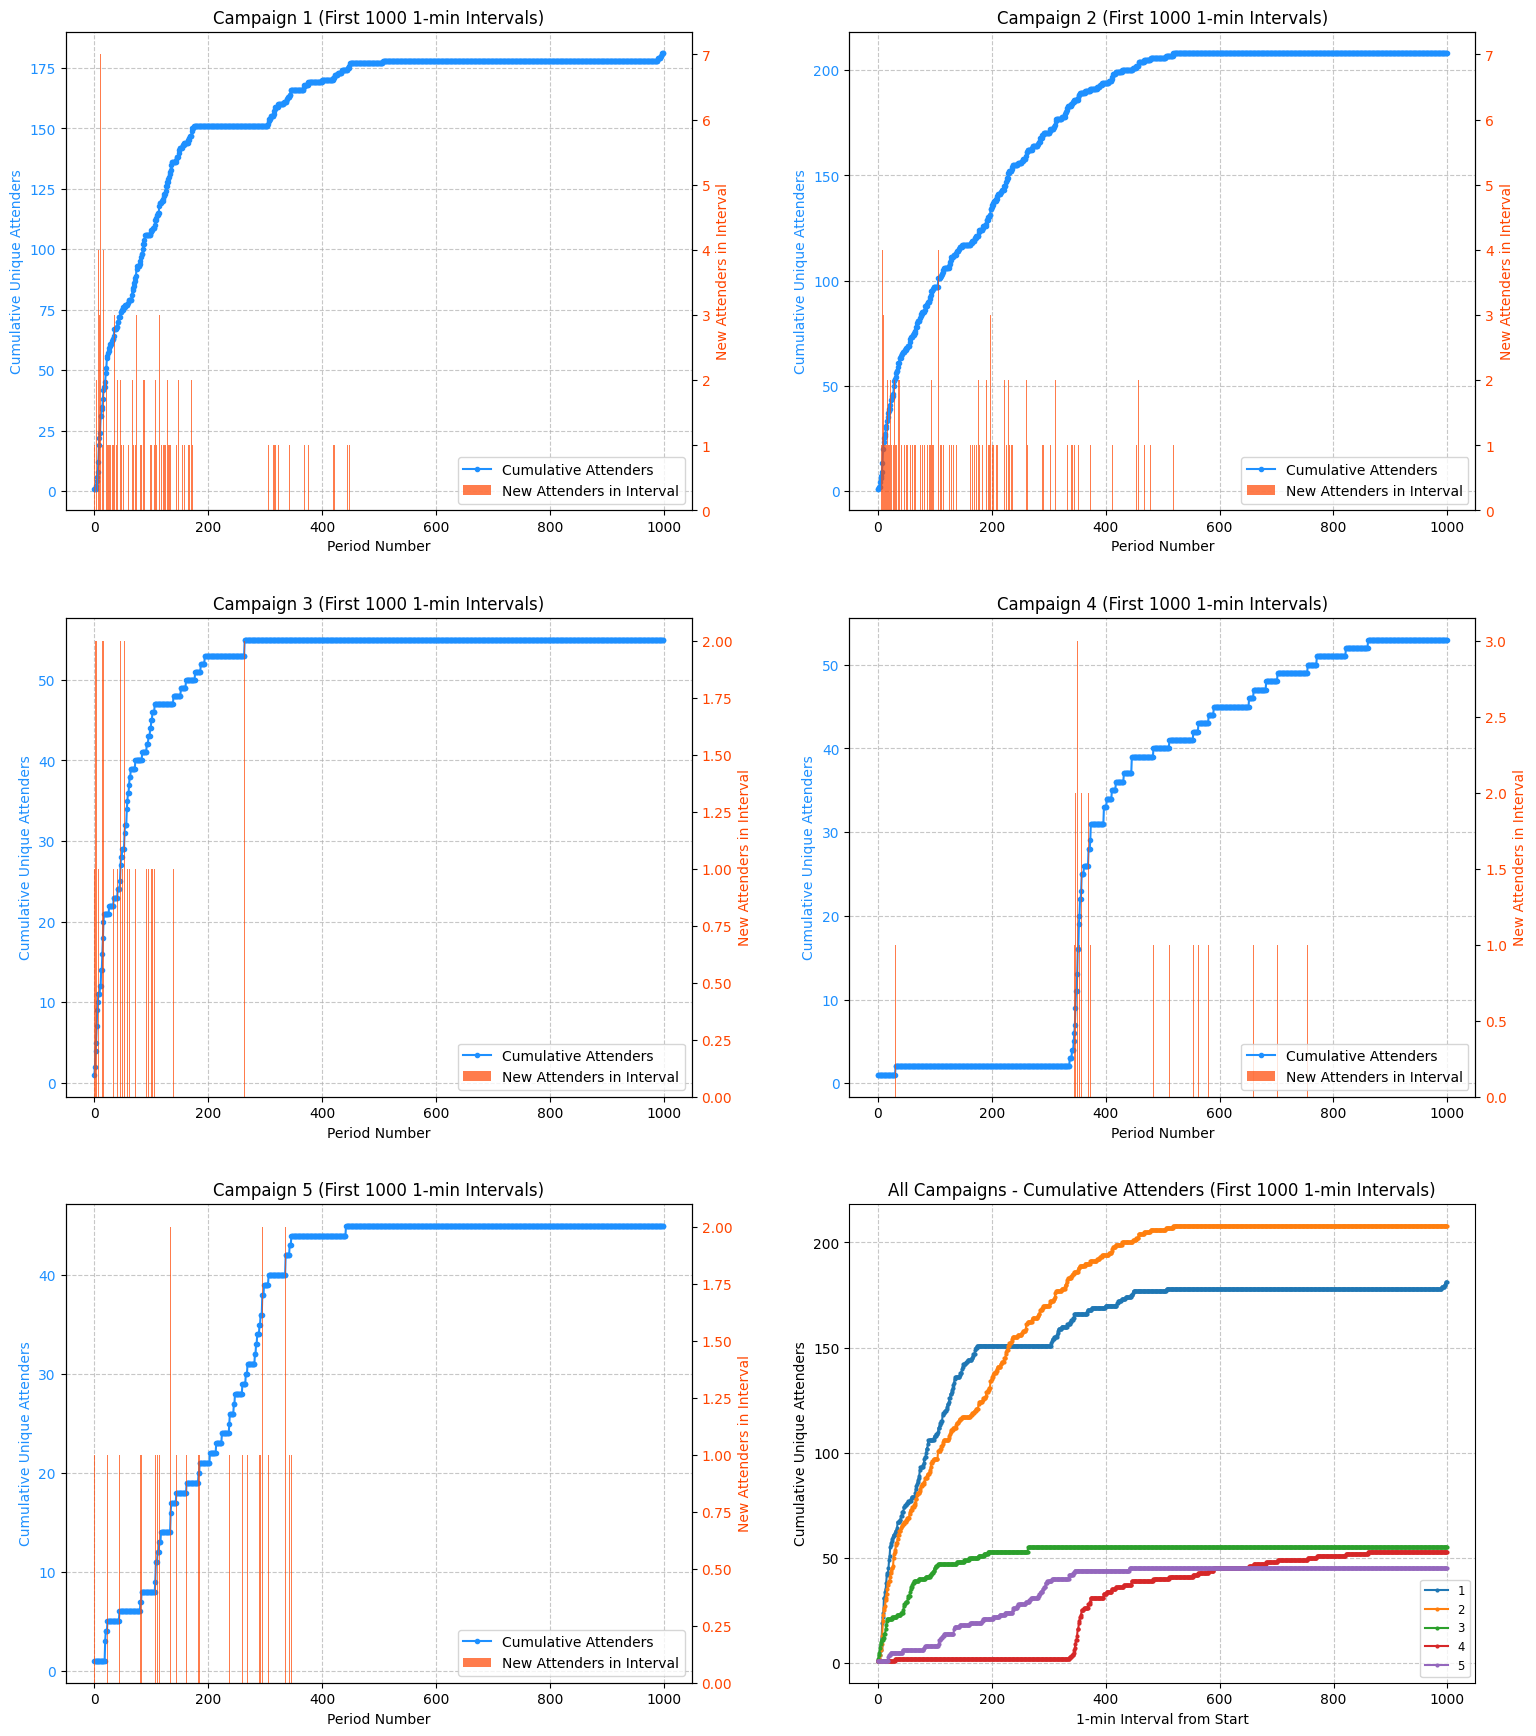

In [6]:
num_intervals_to_plot = 1000

INTERNAL_RESAMPLE_FREQ = 'T'
TIME_UNIT_LABEL = "1-min Interval"  #

campaigns['timestamp'] = pd.to_datetime(campaigns['timestamp'])
campaigns = campaigns.sort_values(by=['campaign_id', 'timestamp'])
unique_campaign_ids = campaigns['campaign_id'].unique()
n_campaigns = len(unique_campaign_ids)

total_plots = n_campaigns + 1
ncols = 2
nrows = (total_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 6), squeeze=False)
axes = axes.flatten()

all_campaign_line_data_for_combined_plot = []

for i, campaign_id_val in enumerate(unique_campaign_ids):
    ax = axes[i]
    campaign_data_for_id = campaigns[campaigns['campaign_id'] == campaign_id_val].copy()

    if campaign_data_for_id.empty:
        ax.set_title(f'Campaign {campaign_id_val} (No data)')
        ax.axis('off')
        continue

    campaign_actual_start_time = campaign_data_for_id['timestamp'].min()

    target_datetime_index = pd.date_range(start=campaign_actual_start_time,
                                          periods=num_intervals_to_plot,
                                          freq=INTERNAL_RESAMPLE_FREQ)

    temp_campaign_data_indexed = campaign_data_for_id.set_index('timestamp')
    resampled_actual_data = temp_campaign_data_indexed.resample(INTERNAL_RESAMPLE_FREQ)['sender_id'] \
                                .apply(lambda x: set(x.unique()))

    senders_at_each_minute = resampled_actual_data.reindex(target_datetime_index)
    senders_at_each_minute = senders_at_each_minute.apply(lambda x: x if isinstance(x, set) else set())

    plot_x_axis_sequence = range(num_intervals_to_plot)

    cumulative_senders_count_list = []
    current_total_unique_senders = set()
    for minute_senders_set in senders_at_each_minute.values:
        current_total_unique_senders.update(minute_senders_set)
        cumulative_senders_count_list.append(len(current_total_unique_senders))

    line_plot_series_numeric_idx = pd.Series(cumulative_senders_count_list, index=plot_x_axis_sequence)

    all_campaign_line_data_for_combined_plot.append({
        'id': campaign_id_val,
        'x_values': list(line_plot_series_numeric_idx.index),
        'y_values': list(line_plot_series_numeric_idx.values)
    })

    new_senders_in_period_list = []
    seen_senders_so_far = set()
    for minute_senders_set in senders_at_each_minute.values:
        newly_seen_this_period = minute_senders_set - seen_senders_so_far
        new_senders_in_period_list.append(len(newly_seen_this_period))
        seen_senders_so_far.update(minute_senders_set)

    bar_plot_series_numeric_idx = pd.Series(new_senders_in_period_list, index=plot_x_axis_sequence)

    color_line = 'dodgerblue'
    ax.set_xlabel('Period Number')
    ax.set_ylabel('Cumulative Unique Attenders', color=color_line)
    ax.plot(line_plot_series_numeric_idx.index, line_plot_series_numeric_idx.values,
            color=color_line, marker='o', markersize=3, linestyle='-', linewidth=1.5,
            label='Cumulative Attenders')
    ax.tick_params(axis='y', labelcolor=color_line)

    ax2 = ax.twinx()
    color_bar = 'orangered'
    ax2.set_ylabel('New Attenders in Interval', color=color_bar)

    # width of bar
    bar_width_numeric = 0.9
    ax2.bar(bar_plot_series_numeric_idx.index, bar_plot_series_numeric_idx.values,
            color=color_bar, alpha=0.7, width=bar_width_numeric,
            label='New Attenders in Interval')

    ax2.tick_params(axis='y', labelcolor=color_bar)

    ax.set_title(f'Campaign {campaign_id_val} (First {num_intervals_to_plot} {TIME_UNIT_LABEL}s)')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    lines1_handles, lines1_labels = ax.get_legend_handles_labels()
    lines2_handles, lines2_labels = ax2.get_legend_handles_labels()
    if lines1_handles or lines2_handles:
        ax2.legend(lines1_handles + lines2_handles, lines1_labels + lines2_labels, loc='lower right')


combined_ax_idx = n_campaigns
combined_ax = axes[combined_ax_idx]

if all_campaign_line_data_for_combined_plot:
    for item in all_campaign_line_data_for_combined_plot:
        campaign_id = item['id']
        x_vals = item['x_values']
        y_vals = item['y_values']
        combined_ax.plot(x_vals, y_vals, marker='.', markersize=4, linestyle='-', linewidth=1.5,
                         label=f'{campaign_id}')

    combined_ax.set_title(f'All Campaigns - Cumulative Attenders (First {num_intervals_to_plot} {TIME_UNIT_LABEL}s)')
    combined_ax.set_xlabel(f'{TIME_UNIT_LABEL} from Start')
    combined_ax.set_ylabel('Cumulative Unique Attenders')
    combined_ax.legend(loc='lower right', fontsize='small')
    combined_ax.grid(True, linestyle='--', alpha=0.7)
    plt.setp(combined_ax.get_xticklabels(), rotation=0, ha="center")
else:
    combined_ax.set_title(f'All Campaigns - Cumulative Attenders (No data for combination)')
    combined_ax.axis('off')

for j in range(total_plots, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)
plt.show()

# Distribution Analyzation


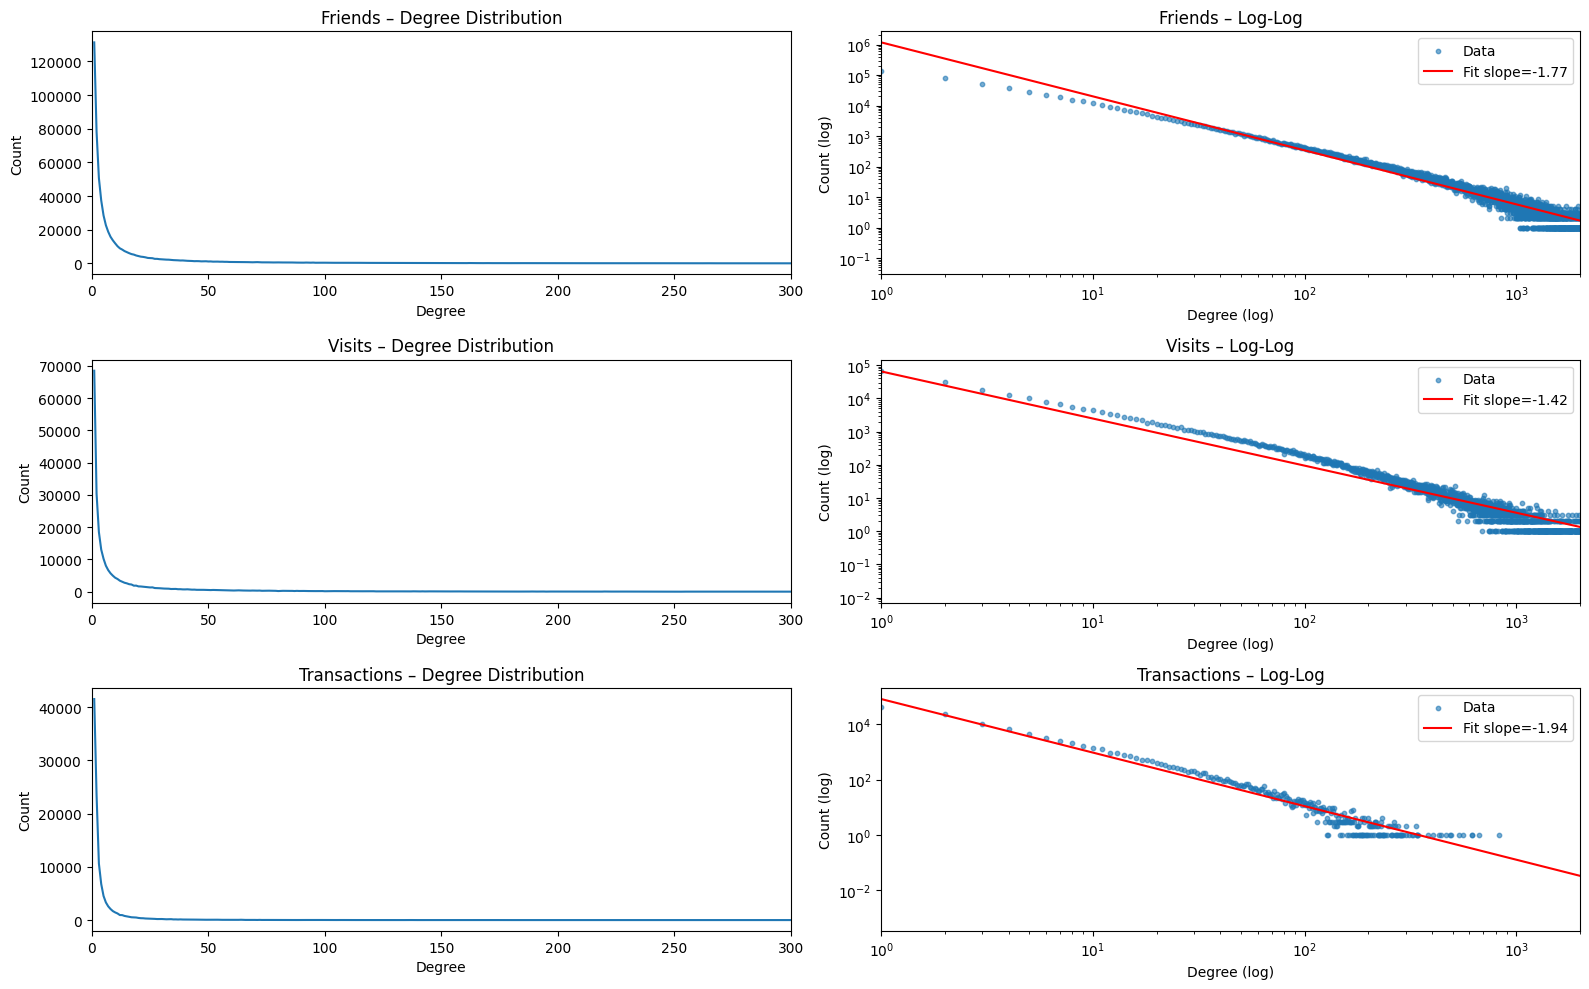

In [7]:
def load_graph(path):
    df = pd.read_csv(path, sep=';', header=None, usecols=[1,2])
    df.columns = ['user_id','othersize_id']

    edges = df.drop_duplicates()
    edges = edges[edges['user_id'] != edges['othersize_id']]

    return ig.Graph.TupleList(
        edges.itertuples(index=False, name=None),
        directed=False,
        vertex_name_attr='name'
    )

def degree_counts(g):
    degs = g.degree()
    cnt = Counter(degs)
    degrees, counts = zip(*sorted(cnt.items()))
    return np.array(degrees), np.array(counts)

g_friends = load_graph('/content/drive/MyDrive/Colab Notebooks/data/ECE227/friends.csv')
g_visits  = load_graph('/content/drive/MyDrive/Colab Notebooks/data/ECE227/visits.csv')
g_transactions = load_graph('/content/drive/MyDrive/Colab Notebooks/data/ECE227/transactions.csv')

deg1, cnt1 = degree_counts(g_friends)
deg2, cnt2 = degree_counts(g_visits)
deg3, cnt3 = degree_counts(g_transactions)

fig, axes = plt.subplots(3, 2, figsize=(16, 10))

# --- friends Linear ---
axes[0,0].plot(deg1, cnt1)
axes[0,0].set_xlim(0, 300)
axes[0,0].set_xlabel('Degree')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Friends – Degree Distribution')

# --- friends Log-Log ---
axes[0,1].scatter(deg1, cnt1, s=10, alpha=0.6, label='Data')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].set_xlim(1, 2000)
# Appro
logx1 = np.log10(deg1); logy1 = np.log10(cnt1)
a1, b1 = np.polyfit(logx1, logy1, 1)
axes[0,1].plot(deg1, 10**(a1*logx1 + b1), color='red',
               label=f'Fit slope={a1:.2f}')
axes[0,1].set_xlabel('Degree (log)')
axes[0,1].set_ylabel('Count (log)')
axes[0,1].set_title('Friends – Log-Log')
axes[0,1].legend()

# --- visits Linear ---
axes[1,0].plot(deg2, cnt2)
axes[1,0].set_xlim(0, 300)
axes[1,0].set_xlabel('Degree')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Visits – Degree Distribution')

# --- visits Log-Log  ---
axes[1,1].scatter(deg2, cnt2, s=10, alpha=0.6, label='Data')
axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log')
axes[1,1].set_xlim(1, 2000)
logx2 = np.log10(deg2); logy2 = np.log10(cnt2)
a2, b2 = np.polyfit(logx2, logy2, 1)
axes[1,1].plot(deg2, 10**(a2*logx2 + b2), color='red',
               label=f'Fit slope={a2:.2f}')
axes[1,1].set_xlabel('Degree (log)')
axes[1,1].set_ylabel('Count (log)')
axes[1,1].set_title('Visits – Log-Log')
axes[1,1].legend()

# --- transactions Linear ---
axes[2,0].plot(deg3, cnt3)
axes[2,0].set_xlim(0, 300)
axes[2,0].set_xlabel('Degree')
axes[2,0].set_ylabel('Count')
axes[2,0].set_title('Transactions – Degree Distribution')

# --- transactions Log-Log ---
axes[2,1].scatter(deg3, cnt3, s=10, alpha=0.6, label='Data')
axes[2,1].set_xscale('log')
axes[2,1].set_yscale('log')
axes[2,1].set_xlim(1, 2000)
logx3 = np.log10(deg3); logy3 = np.log10(cnt3)
a3, b3 = np.polyfit(logx3, logy3, 1)
axes[2,1].plot(deg3, 10**(a3*logx3 + b3), color='red',
               label=f'Fit slope={a3:.2f}')
axes[2,1].set_xlabel('Degree (log)')
axes[2,1].set_ylabel('Count (log)')
axes[2,1].set_title('Transactions – Log-Log')
axes[2,1].legend()

plt.tight_layout()
plt.show()

In [30]:
g_transactions.assortativity_degree(directed=True)

-0.02471665811747694

略微的异配(disassortative) :负值意味着“高度节点更倾向于和低度节点相连”；

但数值接近 0:|-0.0247| 很小，表明这种异配关系非常微弱，整体上网络在度上几乎不表现出明显的同配或异配倾向。

## Analyze the distribution of amount

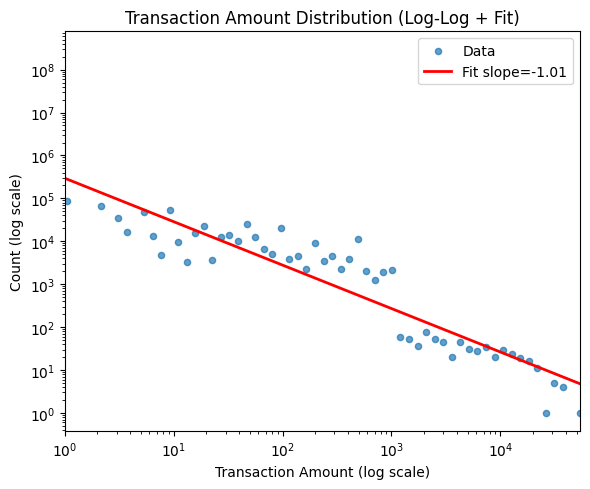

In [8]:
FILE = '/content/drive/MyDrive/Colab Notebooks/data/ECE227/transactions.csv'

# First Scan: Get minimum and maximum amount
min_amt, max_amt = float('inf'), 0.0
for chunk in pd.read_csv(
        FILE, sep=';', header=None,
        names=['timestamp','sender','receiver','amount'],
        usecols=['amount'], chunksize=10**6
    ):
    min_amt = min(min_amt, chunk['amount'].min())
    max_amt = max(max_amt, chunk['amount'].max())
min_amt = max(min_amt, 1e-3)

# define bin
bins = np.logspace(np.log10(min_amt), np.log10(max_amt), num=100)
counts = np.zeros(len(bins)-1, dtype=np.int64)
# Second Scan: get counts  for each bin
for chunk in pd.read_csv(
        FILE, sep=';', header=None,
        names=['timestamp','sender','receiver','amount'],
        usecols=['amount'], chunksize=10**6
    ):
    hist, _ = np.histogram(chunk['amount'], bins=bins)
    counts += hist
bin_centers = np.sqrt(bins[:-1] * bins[1:])

mask = (bin_centers >= 1.0) & (counts > 0)
logx = np.log10(bin_centers[mask])
logy = np.log10(counts[mask])
a, b = np.polyfit(logx, logy, 1)  # log(count) = a*log(amount) + b
y_fit = 10**(a * np.log10(bin_centers) + b)

plt.figure(figsize=(6,5))
plt.scatter(bin_centers, counts, s=20, alpha=0.7, label='Data')
plt.plot(bin_centers, y_fit, color='red', linewidth=2,
         label=f'Fit slope={a:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, bin_centers.max())
plt.xlabel('Transaction Amount (log scale)')
plt.ylabel('Count (log scale)')
plt.title('Transaction Amount Distribution (Log-Log + Fit)')
plt.legend()
plt.tight_layout()
plt.show()

## Average Path Length, Diameter, Global Efficiency
Base on Friends

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

In [ ]:
!python3 rapidsai-csp-utils/colab/pip-install.py

In [4]:
import cugraph
import numpy as np
import cudf
import pandas as pd

# 1) Read CSV in chunks into a cudf.DataFrame
FILE = '/content/drive/MyDrive/Colab Notebooks/data/ECE227/friends.csv'
src_list = []
dst_list = []
for chunk in pd.read_csv(
        FILE, sep=';', header=None,
        names=['ts','u','v'],
        usecols=['u','v'], chunksize=10**6
    ):
    df = chunk[chunk['u'] != chunk['v']].drop_duplicates()
    src_list.append(cudf.from_pandas(df['u']))
    dst_list.append(cudf.from_pandas(df['v']))

# combine into one DataFrame on the GPU
src = cudf.concat(src_list).reset_index(drop=True)
dst = cudf.concat(dst_list).reset_index(drop=True)
gdf = cudf.DataFrame({'src': src, 'dst': dst})

# 2) Build the undirected cuGraph
G = cugraph.Graph()
G.from_cudf_edgelist(gdf, source='src', destination='dst', renumber=False)

# 3) Sample nodes and run BFS, but filter out sentinel distances
np.random.seed(42)
all_nodes = G.nodes().to_pandas().values
sample_nodes = np.random.choice(all_nodes, size=100, replace=False)

# cuGraph uses int64 max (2**63-1) as the unreachable sentinel
sentinel = np.iinfo(np.int64).max

distances = []
for seed in sample_nodes:
    df_bfs = cugraph.bfs(G, start=seed)
    # keep only reachable vertices (distance < sentinel)
    finite = df_bfs[df_bfs['distance'] < int(sentinel)]['distance'].to_pandas().values
    # drop the zero distance to self if you like:
    finite = finite[finite > 0]
    distances.append(finite)

# flatten all distances into one array
all_dists = np.concatenate(distances)

# 4) Approximate Average Shortest Path Length
avg_path_length = all_dists.mean()
print(f"Approx. average shortest path length: {avg_path_length:.3f}")

# 5) Approximate Global Efficiency
eff = np.mean(1.0 / all_dists)
print(f"Approx. global efficiency: {eff:.6f}")

# 6) Approximate Diameter (max over finite sampled distances)
approx_diameter = max(d.max() for d in distances)
print(f"Approx. diameter (over samples): {approx_diameter}")

Approx. average shortest path length: 3.924
Approx. global efficiency: 0.264889
Approx. diameter (over samples): 15
